<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [82]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [83]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

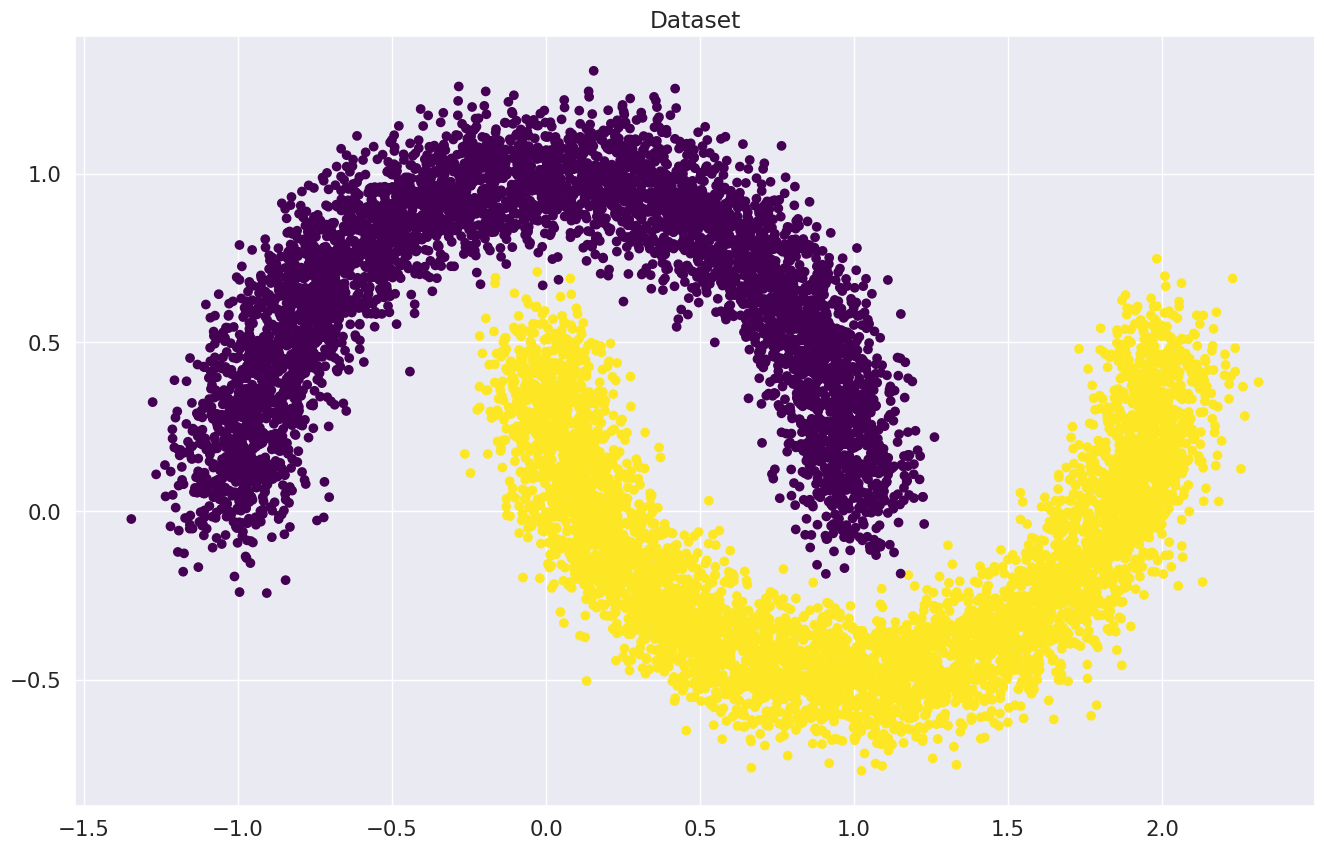

In [84]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [86]:
X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)

Создаем `Dataset` и `DataLoader`.

In [87]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [88]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
          self.bias_term = torch.randn(out_features)  # иниц смещения

    def forward(self, x):
        x = x.mm(self.weights)  # умножаем входные данные на веса
        if self.bias:
          x += self.bias_term  # добавление смещения
        return x

In [89]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [90]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
summary(linear_regression)

Layer (type:depth-idx)                   Param #
LinearRegression                         2
Total params: 2
Trainable params: 2
Non-trainable params: 0

**Ответ: 4**

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [91]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)  # Use linear_regression to get outputs
        loss =  loss_function(outp, y_batch.view(-1, 1))  # Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)  # Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.21875
Iteration: 100
Batch accuracy: 0.546875
Iteration: 200
Batch accuracy: 0.46875
Iteration: 300
Batch accuracy: 0.8046875
Iteration: 400
Batch accuracy: 0.8515625
Iteration: 500
Batch accuracy: 0.859375
Iteration: 600
Batch accuracy: 0.78125
Iteration: 700
Batch accuracy: 0.84375
Iteration: 800
Batch accuracy: 0.8515625
Iteration: 900
Batch accuracy: 0.8359375
Iteration: 1000
Batch accuracy: 0.8671875

Iteration: 1050.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 606

### Визуализируем результаты

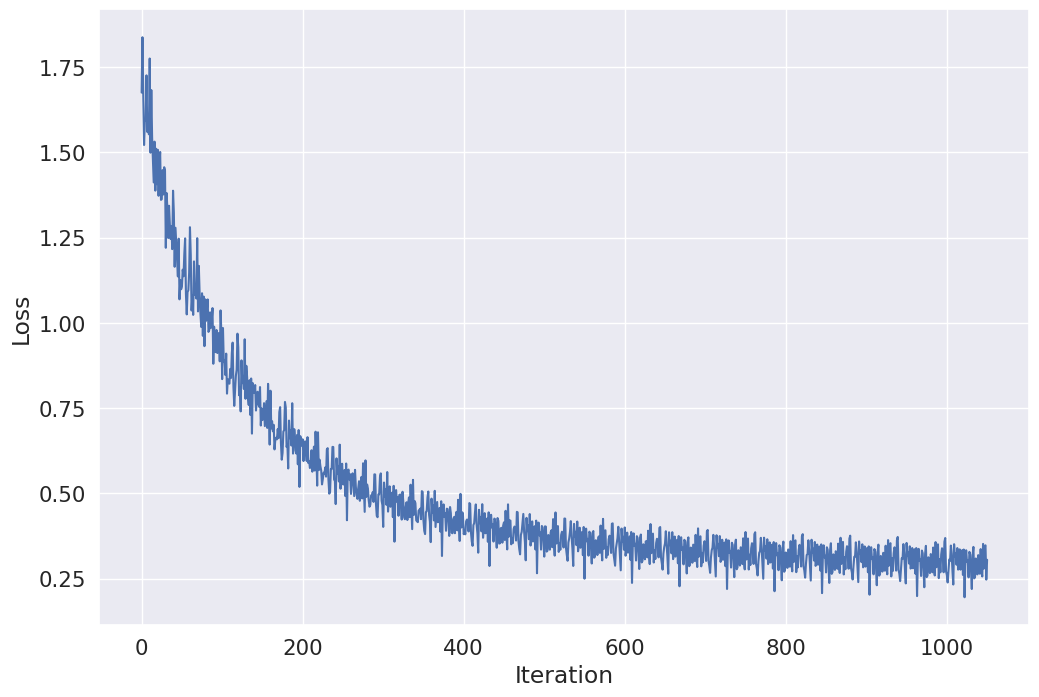

In [92]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

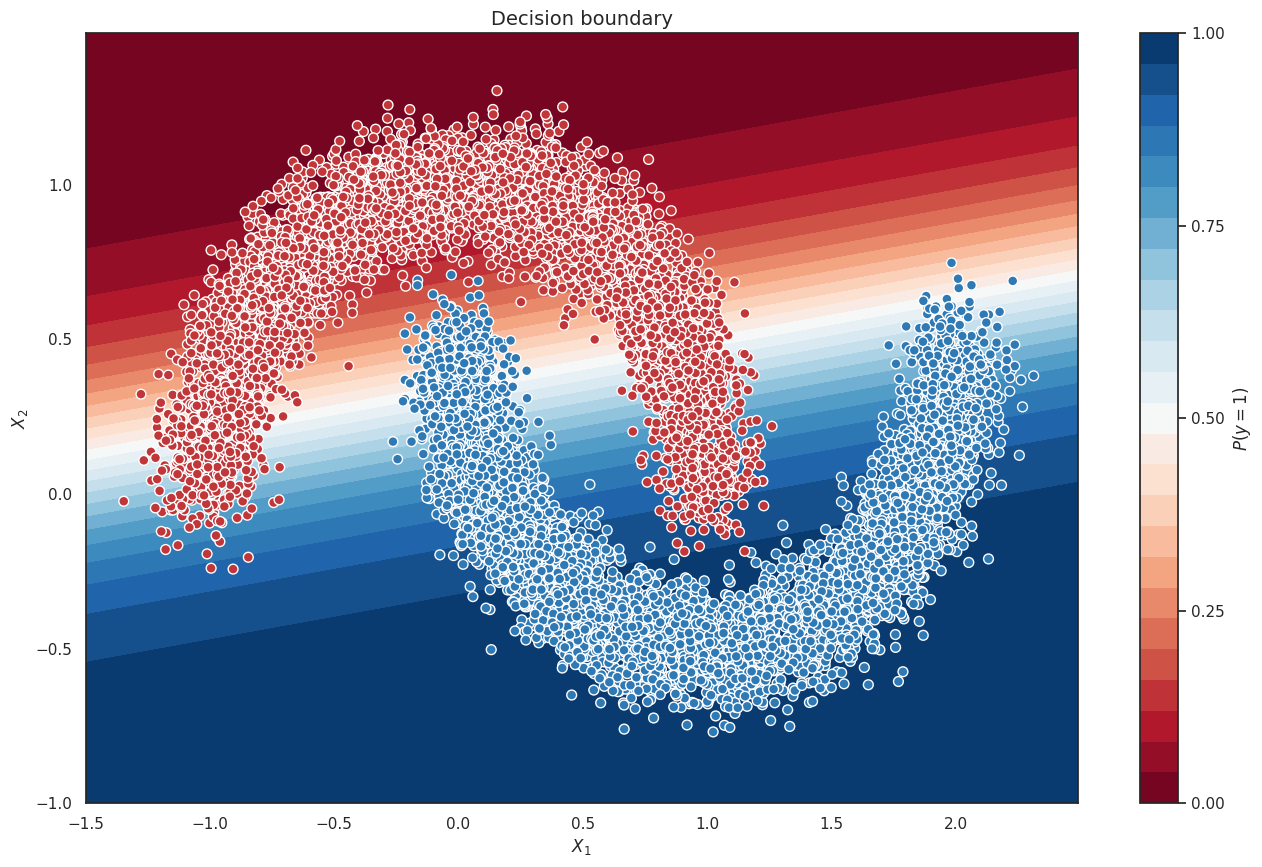

In [93]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [94]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:

        outp =  linear_regression(X_batch)  # Use linear_regression to get outputs
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [95]:
from sklearn.metrics import accuracy_score

test_predictions = predict(val_dataloader, linear_regression)
test_predictions = test_predictions[:2500]
accuracy = accuracy_score(y_val_t, test_predictions)
accuracy

0.5004

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** плохое

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [96]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [97]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [98]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
    nn.Linear(784, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, 10)
)

In [99]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [100]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [101]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 with torch.no_grad():
                     outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  preds[preds==y_batch]
            all =  preds.shape[0]
            epoch_correct += correct.shape[0]
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8799666666666667
Loader: valid. Accuracy: 0.922
Epoch: 2
Loader: train. Accuracy: 0.9423166666666667
Loader: valid. Accuracy: 0.9481
Epoch: 3
Loader: train. Accuracy: 0.9597666666666667
Loader: valid. Accuracy: 0.9575
Epoch: 4
Loader: train. Accuracy: 0.9682333333333333
Loader: valid. Accuracy: 0.9653
Epoch: 5
Loader: train. Accuracy: 0.9743833333333334
Loader: valid. Accuracy: 0.9666
Epoch: 6
Loader: train. Accuracy: 0.9795166666666667
Loader: valid. Accuracy: 0.9659
Epoch: 7
Loader: train. Accuracy: 0.9829
Loader: valid. Accuracy: 0.9653
Epoch: 8
Loader: train. Accuracy: 0.9849166666666667
Loader: valid. Accuracy: 0.967
Epoch: 9
Loader: train. Accuracy: 0.9850166666666667
Loader: valid. Accuracy: 0.9712
Epoch: 10
Loader: train. Accuracy: 0.9845833333333334
Loader: valid. Accuracy: 0.9695


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [102]:
elu_accuracy = accuracy["valid"]
max_epochs = 10

In [103]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    #YOUR CODE
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct =  preds[preds==y_batch]
                all =  preds.shape[0]
                epoch_correct += correct.shape[0]
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy['valid']


In [104]:
plain_accuracy = test_activation_function(nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.Linear(128, 128),
    nn.Linear(128, 10)
    )
)

Epoch: 1
Loader: train. Accuracy: 0.9859
Loader: valid. Accuracy: 0.9699
Epoch: 2
Loader: train. Accuracy: 0.9889
Loader: valid. Accuracy: 0.9685
Epoch: 3
Loader: train. Accuracy: 0.9898666666666667
Loader: valid. Accuracy: 0.9735
Epoch: 4
Loader: train. Accuracy: 0.9905
Loader: valid. Accuracy: 0.9724
Epoch: 5
Loader: train. Accuracy: 0.9906833333333334
Loader: valid. Accuracy: 0.9722
Epoch: 6
Loader: train. Accuracy: 0.9907333333333334
Loader: valid. Accuracy: 0.9739
Epoch: 7
Loader: train. Accuracy: 0.9922166666666666
Loader: valid. Accuracy: 0.9729
Epoch: 8
Loader: train. Accuracy: 0.9925333333333334
Loader: valid. Accuracy: 0.9742
Epoch: 9
Loader: train. Accuracy: 0.99355
Loader: valid. Accuracy: 0.9778
Epoch: 10
Loader: train. Accuracy: 0.99405
Loader: valid. Accuracy: 0.9752


In [105]:
relu_accuracy = test_activation_function(nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
    )
)

Epoch: 1
Loader: train. Accuracy: 0.99385
Loader: valid. Accuracy: 0.9735
Epoch: 2
Loader: train. Accuracy: 0.9936166666666667
Loader: valid. Accuracy: 0.9757
Epoch: 3
Loader: train. Accuracy: 0.9943333333333333
Loader: valid. Accuracy: 0.9748
Epoch: 4
Loader: train. Accuracy: 0.9941
Loader: valid. Accuracy: 0.9725
Epoch: 5
Loader: train. Accuracy: 0.9942166666666666
Loader: valid. Accuracy: 0.9774
Epoch: 6
Loader: train. Accuracy: 0.9961
Loader: valid. Accuracy: 0.9777
Epoch: 7
Loader: train. Accuracy: 0.9952666666666666
Loader: valid. Accuracy: 0.9743
Epoch: 8
Loader: train. Accuracy: 0.9942
Loader: valid. Accuracy: 0.9772
Epoch: 9
Loader: train. Accuracy: 0.9949
Loader: valid. Accuracy: 0.9785
Epoch: 10
Loader: train. Accuracy: 0.99625
Loader: valid. Accuracy: 0.974


In [ ]:
leaky_relu_accuracy = test_activation_function(
    nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 10)
    )
)

Epoch: 1
Loader: train. Accuracy: 0.99545
Loader: valid. Accuracy: 0.9727
Epoch: 2
Loader: train. Accuracy: 0.9952833333333333
Loader: valid. Accuracy: 0.9771
Epoch: 3
Loader: train. Accuracy: 0.9960333333333333
Loader: valid. Accuracy: 0.9774
Epoch: 4
Loader: train. Accuracy: 0.9959166666666667
Loader: valid. Accuracy: 0.9749
Epoch: 5
Loader: train. Accuracy: 0.9953
Loader: valid. Accuracy: 0.9753
Epoch: 6
Loader: train. Accuracy: 0.9964166666666666
Loader: valid. Accuracy: 0.9752
Epoch: 7
Loader: train. Accuracy: 0.9970833333333333
Loader: valid. Accuracy: 0.9736
Epoch: 8
Loader: train. Accuracy: 0.99575
Loader: valid. Accuracy: 0.9726
Epoch: 9
Loader: train. Accuracy: 0.99545
Loader: valid. Accuracy: 0.9716


In [107]:
elu_accuracy = test_activation_function(
    nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, 10)
    )
)

Epoch: 1
Loader: train. Accuracy: 0.9964833333333334
Loader: valid. Accuracy: 0.9769
Epoch: 2
Loader: train. Accuracy: 0.9957666666666667
Loader: valid. Accuracy: 0.9716
Epoch: 3
Loader: train. Accuracy: 0.9959333333333333
Loader: valid. Accuracy: 0.9792
Epoch: 4
Loader: train. Accuracy: 0.9960666666666667
Loader: valid. Accuracy: 0.976
Epoch: 5
Loader: train. Accuracy: 0.9964
Loader: valid. Accuracy: 0.9746
Epoch: 6
Loader: train. Accuracy: 0.9968166666666667
Loader: valid. Accuracy: 0.9752
Epoch: 7
Loader: train. Accuracy: 0.9965833333333334
Loader: valid. Accuracy: 0.9786
Epoch: 8
Loader: train. Accuracy: 0.9976833333333334
Loader: valid. Accuracy: 0.9805
Epoch: 9
Loader: train. Accuracy: 0.9966166666666667
Loader: valid. Accuracy: 0.9708
Epoch: 10
Loader: train. Accuracy: 0.9954666666666667
Loader: valid. Accuracy: 0.9784


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

In [108]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
max_epochs = 10
loaders = {"train": train_dataloader, "valid": valid_dataloader}

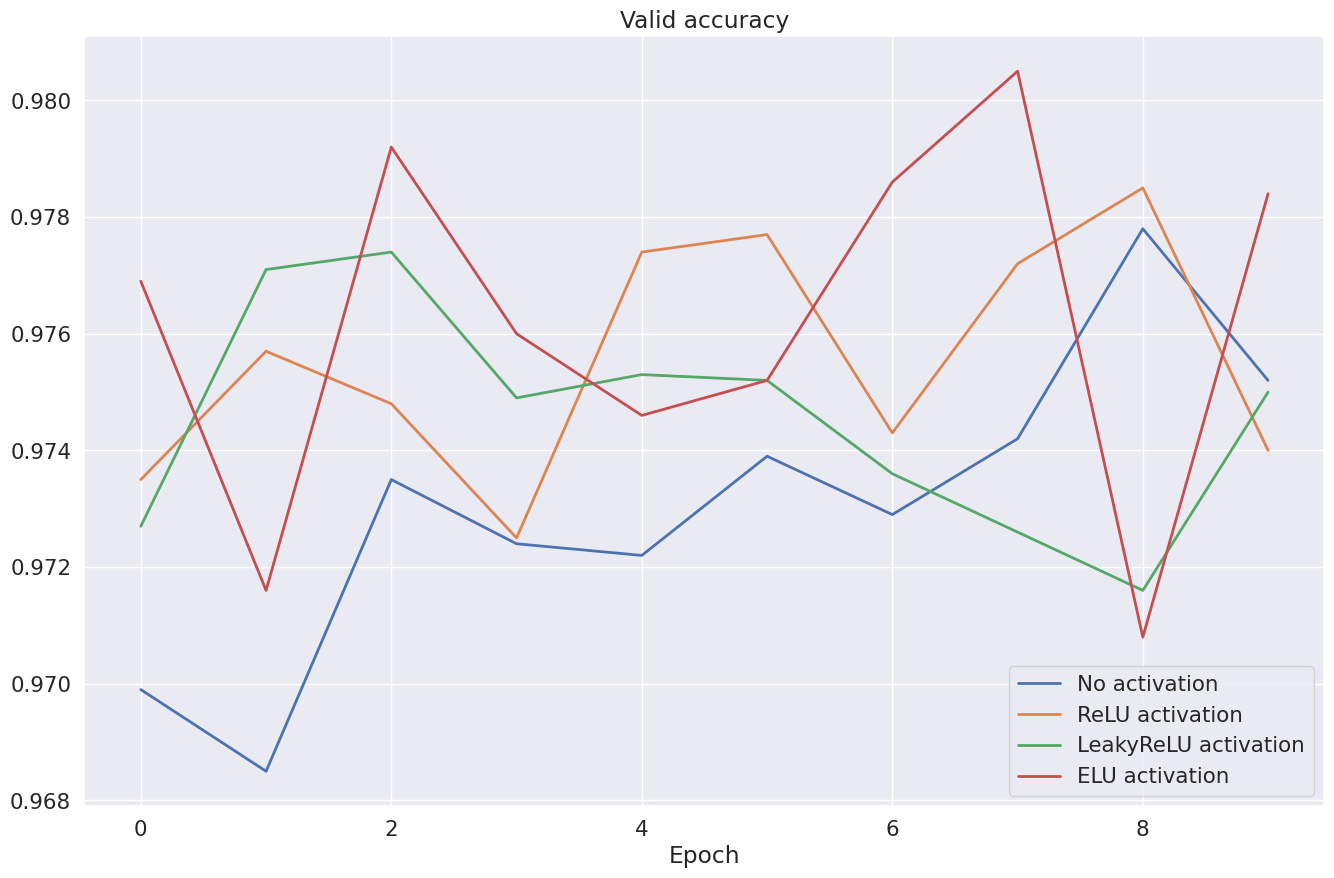

In [109]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [111]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-10-15 12:58:40--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   117KB/s    in 0.4s    

2023-10-15 12:58:41 (117 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



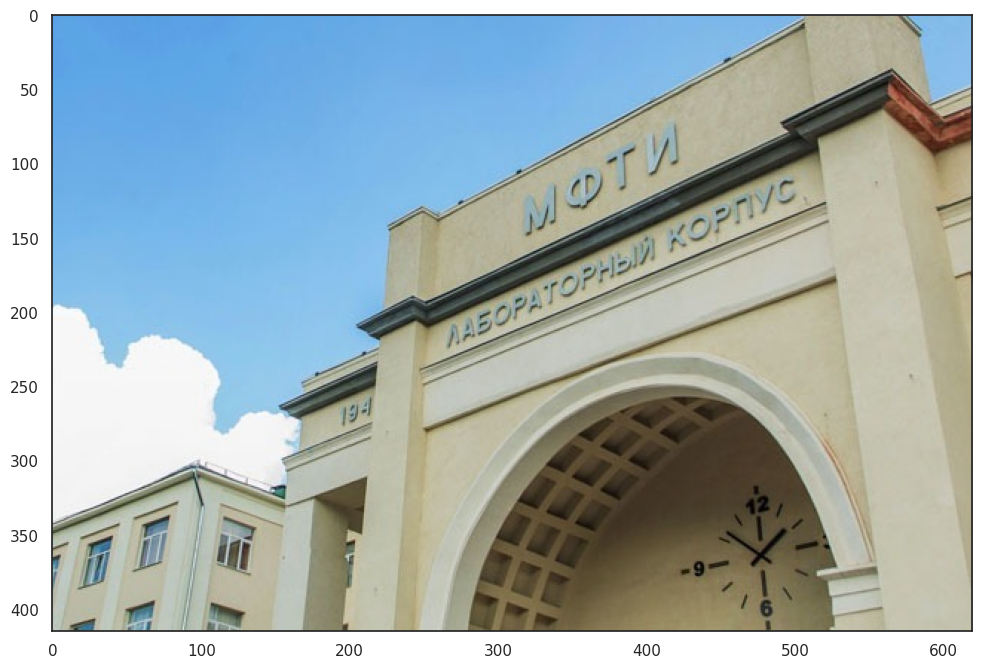

In [112]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [113]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

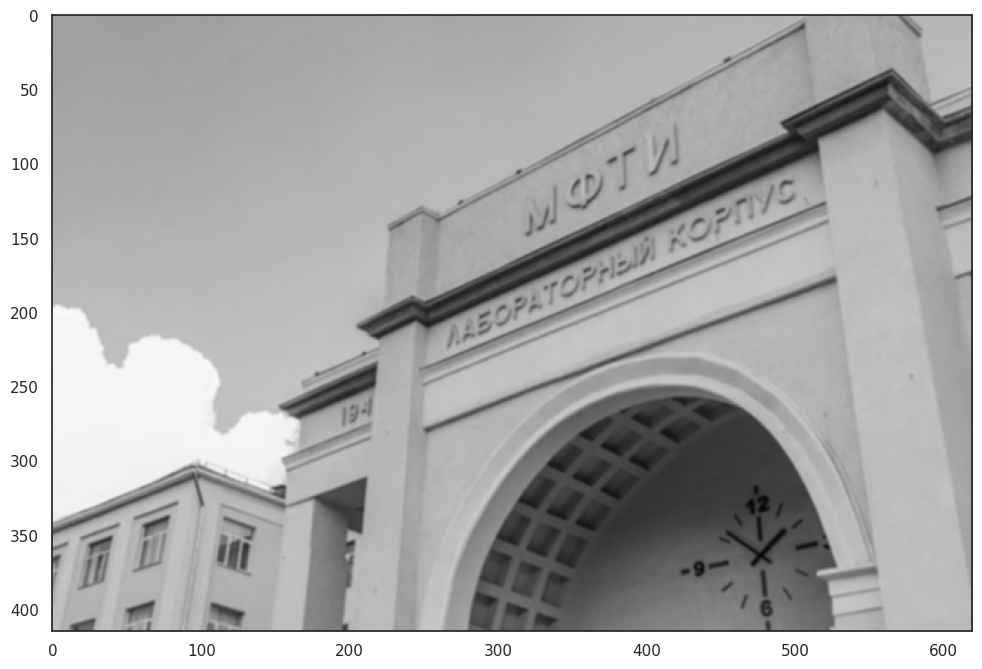

In [114]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - А

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ - Б

6) Выделение границ - Г

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [115]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.flatten = nn.Flatten()
        self.activation = nn.ReLU()

    def forward(self, x):
         x = self.pool1(nn.ReLU()(self.conv1(x)))  #YOUR CODE. Apply layers created in __init__.
         x = self.pool2(nn.ReLU()(self.conv2(x)))
         x = self.flatten(x)
         x = self.activation(self.fc1(x))
         x = self.activation(self.fc2(x))
         x = self.fc3(x)
         return x

In [116]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [117]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 with torch.no_grad():
                     outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  preds[preds==y_batch]
            all =  preds.shape[0]
            epoch_correct += correct.shape[0]
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8673833333333333
Loader: valid. Accuracy: 0.9668
Epoch: 2
Loader: train. Accuracy: 0.9671166666666666
Loader: valid. Accuracy: 0.9721
Epoch: 3
Loader: train. Accuracy: 0.9767
Loader: valid. Accuracy: 0.9744
Epoch: 4
Loader: train. Accuracy: 0.98115
Loader: valid. Accuracy: 0.9774
Epoch: 5
Loader: train. Accuracy: 0.9843333333333333
Loader: valid. Accuracy: 0.9819
Epoch: 6
Loader: train. Accuracy: 0.9868333333333333
Loader: valid. Accuracy: 0.9826
Epoch: 7
Loader: train. Accuracy: 0.9889333333333333
Loader: valid. Accuracy: 0.9825
Epoch: 8
Loader: train. Accuracy: 0.9905833333333334
Loader: valid. Accuracy: 0.9827
Epoch: 9
Loader: train. Accuracy: 0.99195
Loader: valid. Accuracy: 0.9836
Epoch: 10
Loader: train. Accuracy: 0.9929
Loader: valid. Accuracy: 0.9839


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

In [ ]:
print("max_epochs:", max_epochs)
print("relu_accuracy:", relu_accuracy)
print("leaky_relu_accuracy:", leaky_relu_accuracy)
print("elu_accuracy:", elu_accuracy)
print("lenet_accuracy:", lenet_accuracy)


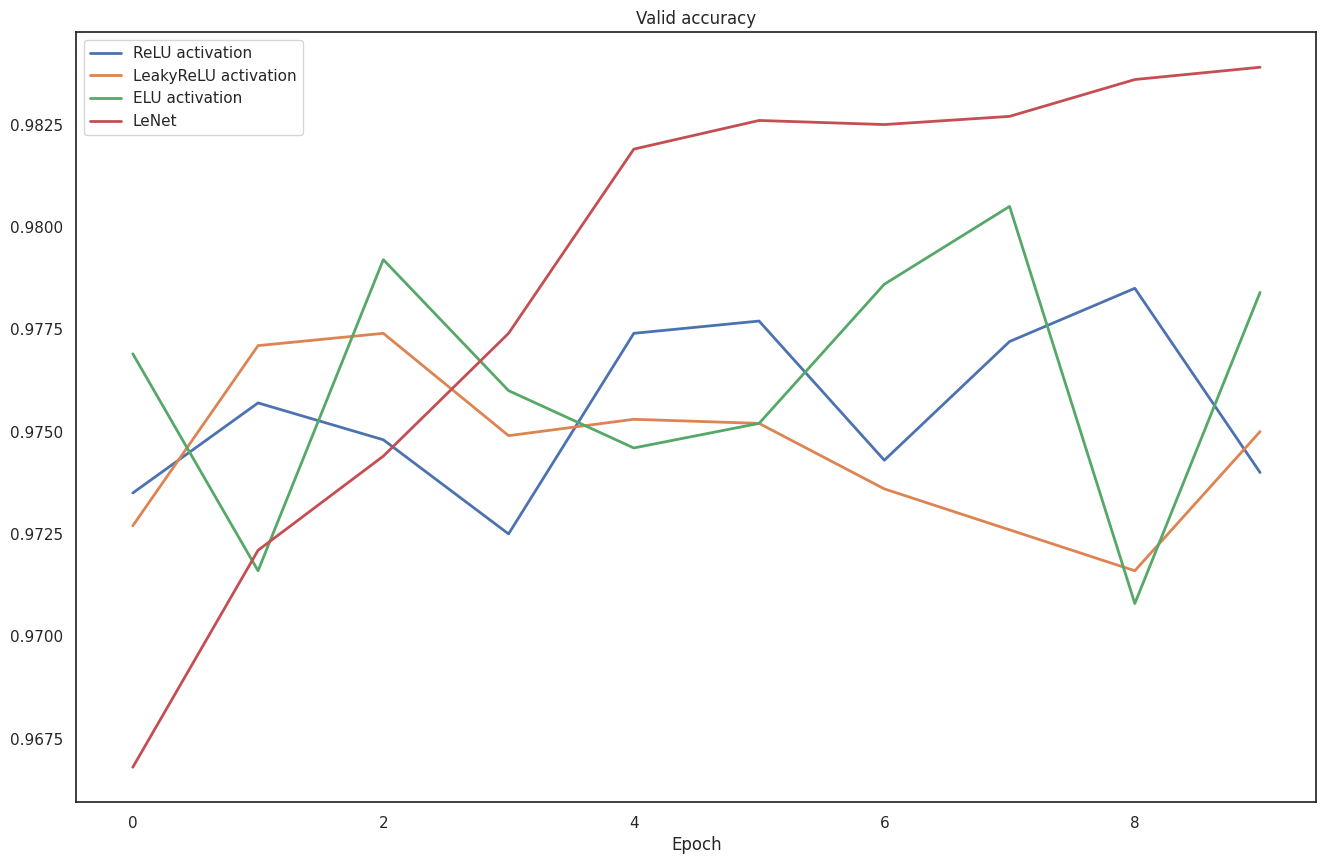

In [120]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0,98